#installing dependencies

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80
Thu Feb 24 22:49:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                           

This notebook works fine with transformers 4.12, it is not tested on newer versions

In [2]:
!pip install transformers==4.12.2
!pip install farasapy==0.0.14
!pip install pyarabic==0.6.14
!git clone https://github.com/aub-mind/arabert
!pip install emoji==1.6.1
!pip install sentencepiece==0.1.96

     |████████████████████████████████| 3.1 MB 12.3 MB/s 
     |████████████████████████████████| 895 kB 40.7 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 39.5 MB/s 
     |████████████████████████████████| 596 kB 42.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 126 kB 12.6 MB/s 
Cloning into 'arabert'...
remote: Enumerating objects: 564, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (252/252), done.
remote: Total 564 (delta 188), reused 247 (delta 92), pack-reused 214
Receiving objects: 100% (564/564), 9.16 MiB | 13.73 MiB/s, done.
Resolving deltas: 100% (311/311), done.
     |████████████████████████████████| 170 kB 12.4 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169313 sha256=fa0119000cdc77b48f9badc

#Creating training datasets

In [3]:
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

This custom dataset class will help us hold our datasets in a structred manner.
It's not necessary to use it with your own data

In [4]:
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [5]:
# This will hold all the downloaded and structred datasets
all_datasets= []
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

You can choose which ever dataset you like or use your own.
At this stage we don't do any preprocessing on the text, this is done later when loading the text.

## Movies

In [6]:
allMovies=pd.read_excel('cima.xlsx')
movies= pd.read_csv('MoviesWithSynopsisAndCategory.csv')
allMovies.replace('لا يوجد ملخص', np.nan, inplace=True)
allMovies.replace('-', np.nan, inplace=True)
allMovies["مدة الفيلم (دقيقة)"] = allMovies["مدة الفيلم (دقيقة)"].astype(float)
allMovies=allMovies[(allMovies['ملخص'].isnull()==False)&(allMovies['تصنيف الفيلم'].isnull()==False)]
allMovies=allMovies.reset_index(drop=True)
movies['Original_Synoposis']=allMovies['ملخص']
# get drama and romance movies only to have 2 labels
movies=movies[(movies['تصنيف الفيلم']=='دراما')|(movies['تصنيف الفيلم']=='رومانسي')|(movies['تصنيف الفيلم']=='كوميدي')|(movies['تصنيف الفيلم']=='ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ')]
movies=movies.reset_index(drop=True)
movies = movies[["Original_Synoposis",'تصنيف الفيلم']]  # we are interested in rating and review only
movies.columns = [DATA_COLUMN, LABEL_COLUMN]
movies["label"].replace('رومانسي', 'romance', inplace=True)
movies["label"].replace('دراما', 'drama', inplace=True)
movies["label"].replace('كوميدي', 'comedy', inplace=True)
movies["label"].replace('ﺗﺸﻮﻳﻖ ﻭﺇﺛﺎﺭﺓ', 'action', inplace=True)
print("Total length: ", len(movies))
print(movies[LABEL_COLUMN].value_counts())

label_list_Movies = list(movies[LABEL_COLUMN].unique())
print(label_list_Movies)

train_movies, test_movies = train_test_split(movies, test_size=0.2, random_state=42)
print("Training length: ", len(train_movies))
print("Testing length: ", len(test_movies))
data_movies = CustomDataset("moviesss", train_movies, test_movies, label_list_Movies)
all_datasets.append(data_movies)

Total length:  1033
drama      556
romance    246
comedy     126
action     105
Name: label, dtype: int64
['romance', 'drama', 'comedy', 'action']
Training length:  826
Testing length:  207


#Trainer

Start the training procedure

In [7]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import copy

from arabert.preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments)
from transformers.data.processors.utils import InputFeatures

List all the datasets we have

In [8]:
for x in all_datasets:
  print(x.name)

moviesss


In [9]:
# select a dataset
dataset_name = 'moviesss'
# select a model from the huggingface modelhub https://huggingface.co/models?language=ar
model_name = 'aubmindlab/bert-base-arabertv02' # we are going to use the twitter AraBERT since it has emojis and dialects

In [10]:
for d in all_datasets:
  if d.name==dataset_name:
    selected_dataset = copy.deepcopy(d)
    print('Dataset found')
    break

Dataset found


Create and apply preprocessing using the AraBERT processor

In [11]:
arabic_prep = ArabertPreprocessor(model_name)

selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))  

In [12]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['( نادية ) تذهب في الليل إلى شقة ( يوسف ) زعيم العصابة ، وتسرق منه 30 ألف جنيه . يفاجأها شخص ويطلق عليها رصاصة ويهرب . عند باب سجن الحضرة ، يجتمع ثلاثة من الموسيقيين أمام السجن ، ينتظرون خرج صديقهم الخارج من السجن ، إنه ( أمين ) الذي يتوجه لتوه إلى منزل مهجور لمقابلة صديقه ( يوسف ) زعيم العصابة ، ويطلب منه حقه فى الجريمة التى دخل من أجلها السجن ، يعطيه عشرة آلاف جنيه من الملابس التى سرقها من ( نادية ) . يطلب منه ( يوسف ) معرفة مكان النقود التى سرقتها ( نادية ) ، وأن يتقرب إليها ، يذهب ( أمين ) مع زملائه الموسيقيين إلى ( نادية ) ويطلب منها أن يعملوا معها . تلحقهم ( نادية ) بفرقتها ، وتحب ( أمين ) ، ويحب كل واحد من الأصدقاء فتاة من الفرقة ، لكن ( يوسف ) زعيم العصابة لا يبدو سعيدا هذا الأمر ، فيرسل تابعة ( رشاد ) من أجل مراقبة تصرفات ( أمين ) . ويجد هذا الأخير قد تزوج من الراقصة ، ويقاوم من أجلها . يقرر ( يوسف ) الانتقام وتتوالى الأحداث .',
 'بعد ثلاث سنوات من الغياب ، يعود ( رجب ) عقب رحلة سفر طويلة قضاها على ظهر إحدى البواخر سعيا لتوفير المال من أجل إتمام زواجه ب ( حميدة ) ، التي تعيش 

Now we need to check the tokenized sentence length to decide on the maximum sentence length value

In [13]:
tok = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/381 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/805k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


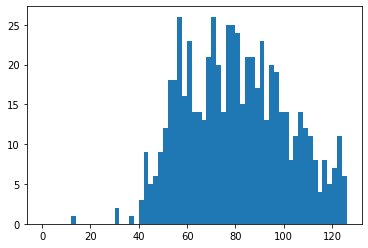

Testing Sentence Lengths: 


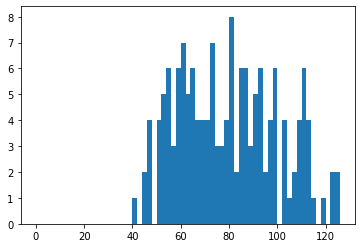

In [14]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,128,2))
plt.show()

Let's select 100 as our maximum sentence length, and check how many sequences will be truncated

In [15]:
max_len = 400

In [16]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  4
Truncated testing sequences:  4


8 out of ~4000 for testing isn't bad

Now let's create a classification dataset to load the data

In [17]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
      super(ClassificationDataset).__init__()
      """
      Args:
      text (List[str]): List of the training text
      target (List[str]): List of the training labels
      tokenizer_name (str): The tokenizer name (same as model_name).
      max_len (int): Maximum sentence length
      label_map (Dict[str,int]): A dictionary that maps the class labels to integer
      """
      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map
      

    def __len__(self):
      return len(self.text)

    def __getitem__(self,item):
      text = str(self.text[item])
      text = " ".join(text.split())
        
      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )      
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [18]:
label_map = { v:index for index, v in enumerate(selected_dataset.label_list) }
print(label_map)

train_dataset = ClassificationDataset(
    selected_dataset.train[DATA_COLUMN].to_list(),
    selected_dataset.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )
test_dataset = ClassificationDataset(
    selected_dataset.test[DATA_COLUMN].to_list(),
    selected_dataset.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

{'romance': 0, 'drama': 1, 'comedy': 2, 'action': 3}


Check the dataset output

In [19]:
print(next(iter(train_dataset)))

InputFeatures(input_ids=[2, 14, 23385, 15, 12249, 305, 6191, 360, 13087, 14, 2328, 15, 5829, 25343, 103, 3064, 548, 1388, 1623, 1276, 2196, 20, 44407, 310, 1057, 24945, 1031, 30770, 48153, 348, 20, 690, 3071, 6493, 19084, 197, 103, 16196, 1643, 306, 38246, 950, 5080, 103, 17360, 5626, 18087, 201, 1032, 306, 5080, 103, 1749, 14, 3363, 15, 425, 12921, 504, 1241, 360, 4088, 1746, 12194, 28505, 18087, 14, 2328, 15, 5829, 25343, 103, 24703, 1388, 9623, 386, 5458, 785, 2792, 306, 21226, 5080, 103, 35501, 2356, 2440, 2196, 306, 9608, 785, 13261, 310, 306, 14, 23385, 15, 20, 6511, 1388, 14, 2328, 15, 5569, 1793, 25705, 785, 48174, 14, 23385, 15, 103, 958, 21891, 348, 2985, 103, 8789, 14, 3363, 15, 354, 11854, 38246, 360, 14, 23385, 15, 24703, 995, 331, 39898, 3324, 20, 25511, 336, 14, 23385, 15, 57584, 551, 103, 2417, 225, 14, 3363, 15, 103, 39671, 459, 1411, 306, 14766, 8412, 306, 9079, 103, 732, 14, 2328, 15, 5829, 25343, 391, 3176, 25350, 434, 1306, 103, 8847, 454, 6042, 14, 24894, 15, 306,

Create a function that return a pretrained model ready to do classification

In [20]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))

Define whatever metric you want here

In [21]:
def compute_metrics(p): #p should be of type EvalPrediction
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)
  #print(classification_report(p.label_ids,preds))
  #print(confusion_matrix(p.label_ids,preds))
  macro_f1 = f1_score(p.label_ids,preds,average='macro')
  #macro_precision = precision_score(p.label_ids,preds,average='macro')
  #macro_recall = recall_score(p.label_ids,preds,average='macro')
  acc = accuracy_score(p.label_ids,preds)
  return {       
      'macro_f1' : macro_f1,
      'accuracy': acc
  }

In [22]:
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic=True
  torch.backends.cudnn.benchmark = False

#Regular Training

Define our training parameters.
Check the TrainingArguments documentation for more options https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [23]:
training_args = TrainingArguments( 
    output_dir= "./train",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False, # enable this when using V100 or T4 GPU
    per_device_train_batch_size = 4, # up to 64 on 16GB with max len of 128
    per_device_eval_batch_size = 400,
    gradient_accumulation_steps = 2, # use this to scale batch size without needing more memory
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True, # this allows to automatically get the best model at the end based on whatever metric we want
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 25
  )

set_seed(training_args.seed)

Create the trainer

In [24]:
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv02 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

In [25]:
#start the training
trainer.train()

***** Running training *****
  Num examples = 826
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 2
  Total optimization steps = 206


Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,1.216917,0.165049,0.492754
1,No log,1.181984,0.165049,0.492754


***** Running Evaluation *****
  Num examples = 207
  Batch size = 400
Saving model checkpoint to ./train/checkpoint-103
Configuration saved in ./train/checkpoint-103/config.json
Model weights saved in ./train/checkpoint-103/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 207
  Batch size = 400
Saving model checkpoint to ./train/checkpoint-206
Configuration saved in ./train/checkpoint-206/config.json
Model weights saved in ./train/checkpoint-206/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train/checkpoint-103 (score: 0.1650485436893204).


TrainOutput(global_step=206, training_loss=1.160584681242415, metrics={'train_runtime': 293.7883, 'train_samples_per_second': 5.623, 'train_steps_per_second': 0.701, 'total_flos': 339172685280000.0, 'train_loss': 1.160584681242415, 'epoch': 2.0})

Save the model, the tokenizer and the config

In [26]:
inv_label_map = inv_label_map = { v:k for k, v in label_map.items()}
print(inv_label_map)
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map
trainer.save_model("output_dir")
train_dataset.tokenizer.save_pretrained("output_dir")

Saving model checkpoint to output_dir
Configuration saved in output_dir/config.json


{0: 'romance', 1: 'drama', 2: 'comedy', 3: 'action'}


Model weights saved in output_dir/pytorch_model.bin
tokenizer config file saved in output_dir/tokenizer_config.json
Special tokens file saved in output_dir/special_tokens_map.json


('output_dir/tokenizer_config.json',
 'output_dir/special_tokens_map.json',
 'output_dir/vocab.txt',
 'output_dir/added_tokens.json',
 'output_dir/tokenizer.json')

In [27]:
#copy the model to drive
!cp output_dir /content/drive/MyDrive

cp: -r not specified; omitting directory 'output_dir'


## predict using the saved model

In [28]:
from transformers import pipeline

In [29]:
# initialize pipline
pipe = pipeline("sentiment-analysis", model="output_dir", device=0, return_all_scores=True)

loading configuration file output_dir/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "romance",
    "1": "drama",
    "2": "comedy",
    "3": "action"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "action": 3,
    "comedy": 2,
    "drama": 1,
    "romance": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file output_d

In [30]:
pipe("Some Text")

[[{'label': 'romance', 'score': 0.2947588562965393},
  {'label': 'drama', 'score': 0.4261220395565033},
  {'label': 'comedy', 'score': 0.13816899061203003},
  {'label': 'action', 'score': 0.14095015823841095}]]

# K-fold

This section is bit more advanced.

We will divide the training set into K-folds and train model with cross-validation to check for the best hyper-parameters before check the performance on the test set.

Alternatively, you can combine the training and testing set if you are participating in a competition, then ensemble the output models

In [31]:
# do kfold on the training. Check the perfomance on the test set
kfold_dataset = selected_dataset.train
# do kfold on all the dataset. Here we will not have any dataset to checl final performance on (this is used mainly in competitions)
# kfold_dataset = pd.concat([selected_dataset.train,selected_dataset.test])
kfold_dataset.reset_index(inplace=True,drop=True)

In [32]:
# this is used later
inv_label_map = { v:k for k, v in label_map.items()}

Defing the number of Stratified kfold splits

In [33]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=123
  )

Train using cross validation and save the best model at each fold

In [34]:
all_results = []
fold_best_f1 = 0
best_fold = None
for fold_num , (train, dev) in enumerate(kf.split(kfold_dataset,kfold_dataset['label'])):
  print("**************************Starting Fold Num: ", fold_num," **************************")
  
  train_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][train]),
                              list(kfold_dataset[LABEL_COLUMN][train]),
                              model_name,
                              max_len,
                              label_map)
  
  val_dataset = ClassificationDataset(list(kfold_dataset[DATA_COLUMN][dev]),
                              list(kfold_dataset[LABEL_COLUMN][dev]),
                              model_name,
                              max_len,
                              label_map)
  
  training_args = TrainingArguments( 
    output_dir= f"./train_{fold_num}",    
    adam_epsilon = 1e-8,
    learning_rate = 2e-5,
    fp16 = False,
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 400,
    gradient_accumulation_steps = 2,
    num_train_epochs= 2,
    warmup_ratio = 0,
    do_eval = True,
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'macro_f1',
    greater_is_better = True,
    seed = 123
  )

  set_seed(training_args.seed)

  trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
  )
  trainer.model.config.label2id = label_map
  trainer.model.config.id2label = inv_label_map

  trainer.train()

  results = trainer.evaluate()
  all_results.append(results)
  print(results)

  trainer.save_model(f"./train_{fold_num}/best_model")
  val_dataset.tokenizer.save_pretrained(f"./train_{fold_num}/best_model")

  # delete the rest of the checkpoints
  !rm -rf f"./train_{fold_num}/checkpoint-*" 
  
  if results['eval_macro_f1'] > fold_best_f1:
    print('**************************New Best Model Found!**************************')
    fold_best_f1 = results['eval_macro_f1']
    best_fold = fold_num

**************************Starting Fold Num:  0  **************************


loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/411eec8d9e12bf4c11eebebb4c5fecd46da787616f45bcfd6cb187e0917afae0.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/vocab.txt from cache at /root/.cache/hugging

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
0,No log,1.171948,0.177043,0.548193
1,No log,1.148315,0.203431,0.560241


***** Running Evaluation *****
  Num examples = 166
  Batch size = 400
Saving model checkpoint to ./train_0/checkpoint-82
Configuration saved in ./train_0/checkpoint-82/config.json
Model weights saved in ./train_0/checkpoint-82/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 166
  Batch size = 400
Saving model checkpoint to ./train_0/checkpoint-164
Configuration saved in ./train_0/checkpoint-164/config.json
Model weights saved in ./train_0/checkpoint-164/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_0/checkpoint-164 (score: 0.2034313725490196).
***** Running Evaluation *****
  Num examples = 166
  Batch size = 400


Saving model checkpoint to ./train_0/best_model
Configuration saved in ./train_0/best_model/config.json


{'eval_loss': 1.1483153104782104, 'eval_macro_f1': 0.2034313725490196, 'eval_accuracy': 0.5602409638554217, 'eval_runtime': 8.8953, 'eval_samples_per_second': 18.662, 'eval_steps_per_second': 0.112, 'epoch': 1.99}


Model weights saved in ./train_0/best_model/pytorch_model.bin
tokenizer config file saved in ./train_0/best_model/tokenizer_config.json
Special tokens file saved in ./train_0/best_model/special_tokens_map.json


**************************New Best Model Found!**************************
**************************Starting Fold Num:  1  **************************


loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/411eec8d9e12bf4c11eebebb4c5fecd46da787616f45bcfd6cb187e0917afae0.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/vocab.txt from cache at /root/.cache/hugging

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,No log,1.176805,0.177734,0.551515
2,No log,1.138925,0.177734,0.551515


***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_1/checkpoint-83
Configuration saved in ./train_1/checkpoint-83/config.json
Model weights saved in ./train_1/checkpoint-83/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_1/checkpoint-166
Configuration saved in ./train_1/checkpoint-166/config.json
Model weights saved in ./train_1/checkpoint-166/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_1/checkpoint-83 (score: 0.177734375).
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400


Saving model checkpoint to ./train_1/best_model
Configuration saved in ./train_1/best_model/config.json


{'eval_loss': 1.176804542541504, 'eval_macro_f1': 0.177734375, 'eval_accuracy': 0.5515151515151515, 'eval_runtime': 8.8468, 'eval_samples_per_second': 18.651, 'eval_steps_per_second': 0.113, 'epoch': 2.0}


Model weights saved in ./train_1/best_model/pytorch_model.bin
tokenizer config file saved in ./train_1/best_model/tokenizer_config.json
Special tokens file saved in ./train_1/best_model/special_tokens_map.json


**************************Starting Fold Num:  2  **************************


loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/411eec8d9e12bf4c11eebebb4c5fecd46da787616f45bcfd6cb187e0917afae0.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/vocab.txt from cache at /root/.cache/hugging

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,No log,1.140838,0.177734,0.551515
2,No log,1.115619,0.177734,0.551515


***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_2/checkpoint-83
Configuration saved in ./train_2/checkpoint-83/config.json
Model weights saved in ./train_2/checkpoint-83/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_2/checkpoint-166
Configuration saved in ./train_2/checkpoint-166/config.json
Model weights saved in ./train_2/checkpoint-166/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_2/checkpoint-83 (score: 0.177734375).
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400


Saving model checkpoint to ./train_2/best_model
Configuration saved in ./train_2/best_model/config.json


{'eval_loss': 1.1408380270004272, 'eval_macro_f1': 0.177734375, 'eval_accuracy': 0.5515151515151515, 'eval_runtime': 8.8738, 'eval_samples_per_second': 18.594, 'eval_steps_per_second': 0.113, 'epoch': 2.0}


Model weights saved in ./train_2/best_model/pytorch_model.bin
tokenizer config file saved in ./train_2/best_model/tokenizer_config.json
Special tokens file saved in ./train_2/best_model/special_tokens_map.json


**************************Starting Fold Num:  3  **************************


loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/411eec8d9e12bf4c11eebebb4c5fecd46da787616f45bcfd6cb187e0917afae0.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/vocab.txt from cache at /root/.cache/hugging

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,No log,1.149031,0.176471,0.545455
2,No log,1.139818,0.176471,0.545455


***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_3/checkpoint-83
Configuration saved in ./train_3/checkpoint-83/config.json
Model weights saved in ./train_3/checkpoint-83/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_3/checkpoint-166
Configuration saved in ./train_3/checkpoint-166/config.json
Model weights saved in ./train_3/checkpoint-166/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_3/checkpoint-83 (score: 0.1764705882352941).
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400


Saving model checkpoint to ./train_3/best_model
Configuration saved in ./train_3/best_model/config.json


{'eval_loss': 1.1490310430526733, 'eval_macro_f1': 0.1764705882352941, 'eval_accuracy': 0.5454545454545454, 'eval_runtime': 8.8515, 'eval_samples_per_second': 18.641, 'eval_steps_per_second': 0.113, 'epoch': 2.0}


Model weights saved in ./train_3/best_model/pytorch_model.bin
tokenizer config file saved in ./train_3/best_model/tokenizer_config.json
Special tokens file saved in ./train_3/best_model/special_tokens_map.json


**************************Starting Fold Num:  4  **************************


loading configuration file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/411eec8d9e12bf4c11eebebb4c5fecd46da787616f45bcfd6cb187e0917afae0.2f0d0092105af7b8b42b899ffb7f801dc48e93516d509483f6cfbd86155d49ea
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading file https://huggingface.co/aubmindlab/bert-base-arabertv02/resolve/main/vocab.txt from cache at /root/.cache/hugging

Epoch,Training Loss,Validation Loss,Macro F1,Accuracy
1,No log,1.141490,0.177734,0.551515
2,No log,1.133697,0.191252,0.557576


***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_4/checkpoint-83
Configuration saved in ./train_4/checkpoint-83/config.json
Model weights saved in ./train_4/checkpoint-83/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400
Saving model checkpoint to ./train_4/checkpoint-166
Configuration saved in ./train_4/checkpoint-166/config.json
Model weights saved in ./train_4/checkpoint-166/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./train_4/checkpoint-166 (score: 0.19125188536953244).
***** Running Evaluation *****
  Num examples = 165
  Batch size = 400


Saving model checkpoint to ./train_4/best_model
Configuration saved in ./train_4/best_model/config.json


{'eval_loss': 1.1336973905563354, 'eval_macro_f1': 0.19125188536953244, 'eval_accuracy': 0.5575757575757576, 'eval_runtime': 8.8785, 'eval_samples_per_second': 18.584, 'eval_steps_per_second': 0.113, 'epoch': 2.0}


Model weights saved in ./train_4/best_model/pytorch_model.bin
tokenizer config file saved in ./train_4/best_model/tokenizer_config.json
Special tokens file saved in ./train_4/best_model/special_tokens_map.json


In [35]:
all_results

[{'epoch': 1.99,
  'eval_accuracy': 0.5602409638554217,
  'eval_loss': 1.1483153104782104,
  'eval_macro_f1': 0.2034313725490196,
  'eval_runtime': 8.8953,
  'eval_samples_per_second': 18.662,
  'eval_steps_per_second': 0.112},
 {'epoch': 2.0,
  'eval_accuracy': 0.5515151515151515,
  'eval_loss': 1.176804542541504,
  'eval_macro_f1': 0.177734375,
  'eval_runtime': 8.8468,
  'eval_samples_per_second': 18.651,
  'eval_steps_per_second': 0.113},
 {'epoch': 2.0,
  'eval_accuracy': 0.5515151515151515,
  'eval_loss': 1.1408380270004272,
  'eval_macro_f1': 0.177734375,
  'eval_runtime': 8.8738,
  'eval_samples_per_second': 18.594,
  'eval_steps_per_second': 0.113},
 {'epoch': 2.0,
  'eval_accuracy': 0.5454545454545454,
  'eval_loss': 1.1490310430526733,
  'eval_macro_f1': 0.1764705882352941,
  'eval_runtime': 8.8515,
  'eval_samples_per_second': 18.641,
  'eval_steps_per_second': 0.113},
 {'epoch': 2.0,
  'eval_accuracy': 0.5575757575757576,
  'eval_loss': 1.1336973905563354,
  'eval_macro_f1

In [36]:
from statistics import mean
mean([x['eval_macro_f1'] for x in all_results])

0.18532451923076923

After checking for the best hyper parameters you should use the regular training section and retrain the model with the parameters that you had here.

Or Ensemble the models together.

## Ensemble all the cross validation models

In [37]:
from transformers import pipeline
import more_itertools

In [38]:
inv_label_map = { v:k for k, v in label_map.items()}

Load some file which has text that we need to run inference on. 
I will use the test set for that

In [39]:
# pred_df = prediction['Text']
# pred_df = pred_df.apply(lambda x:   arabic_prep.preprocess(x))

pred_df = selected_dataset.test[DATA_COLUMN]

In [40]:
cross_val_df = pd.DataFrame([])
for i in range(0,5):
  pipe = pipeline("sentiment-analysis", model=f"train_{i}/best_model", device=0, return_all_scores =True, max_length=max_len, truncation=True)
  preds = []
  for s in tqdm(more_itertools.chunked(list(pred_df), 32)): # batching for faster inference
    preds.extend(pipe(s))
  cross_val_df[f'model_{i}'] = preds

loading configuration file train_0/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "romance",
    "1": "drama",
    "2": "comedy",
    "3": "action"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "action": 3,
    "comedy": 2,
    "drama": 1,
    "romance": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file 

0it [00:00, ?it/s]

Disabling tokenizer parallelism, we're using DataLoader multithreading already
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
loading configuration file train_1/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "romance",
    "1": "drama",
    "2": "comedy",
    "3": "action"
  },
  "initializer_range": 0

0it [00:00, ?it/s]

loading configuration file train_2/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "romance",
    "1": "drama",
    "2": "comedy",
    "3": "action"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "action": 3,
    "comedy": 2,
    "drama": 1,
    "romance": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file 

0it [00:00, ?it/s]

loading configuration file train_3/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "romance",
    "1": "drama",
    "2": "comedy",
    "3": "action"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "action": 3,
    "comedy": 2,
    "drama": 1,
    "romance": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file 

0it [00:00, ?it/s]

loading configuration file train_4/best_model/config.json
Model config BertConfig {
  "_name_or_path": "aubmindlab/bert-base-arabertv02",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "romance",
    "1": "drama",
    "2": "comedy",
    "3": "action"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "action": 3,
    "comedy": 2,
    "drama": 1,
    "romance": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 64000
}

loading configuration file 

0it [00:00, ?it/s]

In [41]:
from collections import defaultdict

final_labels = []
final_scores = []
for id, row in cross_val_df.iterrows():
  total_score = defaultdict(lambda: 0)  
  for pred in row:
    for cls in pred:
      total_score[cls['label']] += cls['score']

  avg_score = { k: v/ 5 for k, v in total_score.items()}

  final_labels.append(max(avg_score, key=avg_score.get))
  final_scores.append(avg_score[max(avg_score, key=avg_score.get)])

In [42]:
cross_val_df['preds'] = final_labels 
cross_val_df['sentiment_score'] = final_scores 

In [43]:
cross_val_df['preds'].value_counts()

drama    207
Name: preds, dtype: int64

In [44]:
print(classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

              precision    recall  f1-score   support

      action       0.00      0.00      0.00        18
      comedy       0.00      0.00      0.00        33
       drama       0.49      1.00      0.66       102
     romance       0.00      0.00      0.00        54

    accuracy                           0.49       207
   macro avg       0.12      0.25      0.17       207
weighted avg       0.24      0.49      0.33       207



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
from sklearn import metrics
print(metrics.confusion_matrix(selected_dataset.test[LABEL_COLUMN], cross_val_df['preds']))
# Printing the precision and recall, among other metrics
print(metrics.classification_report(selected_dataset.test[LABEL_COLUMN],cross_val_df['preds']))

[[  0   0  18   0]
 [  0   0  33   0]
 [  0   0 102   0]
 [  0   0  54   0]]
              precision    recall  f1-score   support

      action       0.00      0.00      0.00        18
      comedy       0.00      0.00      0.00        33
       drama       0.49      1.00      0.66       102
     romance       0.00      0.00      0.00        54

    accuracy                           0.49       207
   macro avg       0.12      0.25      0.17       207
weighted avg       0.24      0.49      0.33       207



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
